# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Standard Section 1: Introduction to Web Scraping

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
**Section Leaders**: Marios Mattheakis, Abhimanyu (Abhi) Vasishth, Robbert (Rob) Struyven<br/>



<hr style='height:2px'>

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

When we're done today, you will approach messy real-world data with confidence that you can get it into a format that you can manipulate.

Specifically, our learning objectives are:
* Understand the structure of an HTML document and use that structure to extract desired information
* Use Python data structures such as lists, dictionaries, and Pandas DataFrames to store and manipulate information
* Identify some other (semi-)structured formats commonly used for storing and transferring data, such as JSON and CSV
* Practice using [Python](https://docs.python.org/3.6/) packages such as [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) and [Pandas](https://pandas.pydata.org/pandas-docs/stable/), including how to navigate their documentation to find functionality.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook")
import json

import requests
from bs4 import BeautifulSoup
from IPython.display import HTML

In [3]:
# Setting up 'requests' to make HTTPS requests properly takes some extra steps... we'll skip them for now.
requests.packages.urllib3.disable_warnings()

import warnings
warnings.filterwarnings("ignore")

## Goals

Is science becoming more collaborative over time? How about literature? Are there a few "geniuses" or lots of hard workers? One way we might answer those questions is by looking at Nobel Prizes. We could ask questions like:

* Has anyone won a prize more than once?
* How has the total number of recipients changed over time?
* How has the number of recipients per award changed over time?


To answer these questions, we'll need data: *who* received *what* award *when*. 

Before we dive into acquiring this data the way we've been teaching in class, let's pause to ask: **what are 5 different approaches we could take to acquiring Nobel Prize data**?





## When possible: find a structured dataset (.csv,.json,.xls)

After a google search we stumble upon this [dataset on github](https://github.com/OpenRefine/OpenRefine/blob/master/main/tests/data/nobel-prize-winners.csv). It is also in the section folder named `github-nobel-prize-winners.csv`.

We use pandas to read it: 

In [4]:
df = pd.read_csv("../data/github-nobel-prize-winners.csv")
df.head()

,year,discipline,winner,desc
0,1901,chemistry,Jacobus H. van 't Hoff,in recognition of the extraordinary services h...
1,1901,literature,Sully Prudhomme,in special recognition of his poetic compositi...
2,1901,medicine,Emil von Behring,"for his work on serum therapy, especially its ..."
3,1901,peace,Henry Dunant,NaN
4,1901,peace,Fr&eacute;d&eacute;ric Passy,NaN


Or you may want to read an xlsx file:

(Potential missing package; you might need to run the following command in your terminal first: ```!conda install xlrd```)

In [5]:
df = pd.read_excel("../data/github-nobel-prize-winners.xlsx")
df.head()

,year,discipline,winner,desc
0,1901,chemistry,Jacobus H. van 't Hoff,in recognition of the extraordinary services h...
1,1901,literature,Sully Prudhomme,in special recognition of his poetic compositi...
2,1901,medicine,Emil von Behring,"for his work on serum therapy, especially its ..."
3,1901,peace,Henry Dunant,NaN
4,1901,peace,Fr&eacute;d&eacute;ric Passy,NaN


## QUIZ: Did anyone recieve the Nobel Prize more than once?

**How would you check if anyone recieved more than one nobel prize?**

In [10]:
# list storing all the names 
name_winners = []
for name in df.winner:
    # Check if we already encountered this name: 
    if name in name_winners:
        # if so, print the name
        if name != "No Prize was Awarded":
            print(name)
    else:
        # otherwise add the name to the list
        name_winners.append(name)

Marie Curie
International Committee of the Red Cross
Linus Pauling
International Committee of the Red Cross
John Bardeen
Frederick Sanger
Office of the United Nations High Commissioner for Refugees


**We don't want to print "No Prize was Awarded" all the time.**

In [11]:
# Your code here


**How can we make this into a oneligner?**

In [12]:
winners = []
[print(name) if (name in winners and name != "No Prize was Awarded") 
 else winners.append(name) for name in df.winner];

Marie Curie
International Committee of the Red Cross
Linus Pauling
International Committee of the Red Cross
John Bardeen
Frederick Sanger
Office of the United Nations High Commissioner for Refugees


## Otherwhise: WEB SCRAPING

Turns out that https://www.nobelprize.org/prizes/lists/all-nobel-prizes/ has the data we want. 

Let's take a look at the [website](https://www.nobelprize.org/prizes/lists/all-nobel-prizes/) and to look at the underhood HTML: right-click and click on `inspect` . Try to find structure in the tree-structured HTML.

------

But the `nobelprize.org` server is a little slow sometimes. Fortunately, the Internet Archive periodically crawls most of the Internet and saves what it finds. (That's a lot of data!) So let's grab the data from the Archive's "Wayback Machine" (great name!).

We'll just give you the direct URL, but at the very end you'll see how we can get it out of a JSON response from the Wayback Machine API.

In [13]:
snapshot_url = 'http://web.archive.org/web/20180820111639/https://www.nobelprize.org/prizes/lists/all-nobel-prizes/'

In [16]:
snapshot = requests.get(snapshot_url)
snapshot

<Response [200]>

What is a this Response [200]? Let's google: [`response 200 meaning`](https://www.google.com/search?q=response+200+meaning&oq=response+%5B200%5D+m&aqs=chrome.1.69i57j0l5.6184j0j7&sourceid=chrome&ie=UTF-8). All possible codes [here](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status).

In [17]:
type(snapshot)

requests.models.Response

Try to request "www.xoogle.be"? What happens?

In [18]:
snapshot_url2 = 'http://web.archive.org/web/20180820111639/https://www.xoogle.be'
snapshot = requests.get(snapshot_url2)
snapshot

<Response [404]>

Always remember to “not to be evil” when scraping with requests! If downloading multiple pages (like you will be on HW1), always put a delay between requests (e.g, `time.sleep(1)`, with the `time` library) so you don’t unwittingly hammer someone’s webserver and/or get blocked.

In [19]:
snapshot = requests.get(snapshot_url)
raw_html = snapshot.text
print(raw_html[:500])

	<!DOCTYPE html>

	<html lang="en-US" prefix="og: http://ogp.me/ns#" class="no-js">

	<head><script src="//archive.org/includes/analytics.js?v=cf34f82" type="text/javascript"></script>
<script type="text/javascript">window.addEventListener('DOMContentLoaded',function(){var v=archive_analytics.values;v.service='wb';v.server_name='wwwb-app42.us.archive.org';v.server_ms=1379;archive_analytics.send_pageview({});});</script><script type="text/javascript" src="/_static/js/ait-client-rewrite.js" charse


## Regular Expressions
You can find specific patterns or strings in text by using Regular Expressions: This is a pattern matching mechanism used throughout Computer Science and programming (it's not just specific to Python). Some great resources that we recommend, if you are interested in them (could be very useful for a homework problem):
- https://docs.python.org/3.3/library/re.html
- https://regexone.com
- https://docs.python.org/3/howto/regex.html.

Specify a specific sequence with the help of regex special characters. Some examples: 
- ```\S``` : Matches any character which is not a Unicode whitespace character
- ```\d``` : Matches any Unicode decimal digit 
- ```*``` : Causes the resulting RE to match 0 or more repetitions of the preceding RE, as many repetitions as are possible.

**Let's find all the occurances of 'Marie' in our raw_html:**

In [20]:
import re 

In [21]:
re.findall(r'Marie',raw_html)

['Marie', 'Marie', 'Marie', 'Marie', 'Marie', 'Marie']

**Using ```\S``` to match 'Marie' + ' ' + 'any character which is not a Unicode whitespace character':**

In [22]:
re.findall(r'Marie \S',raw_html)

['Marie G', 'Marie L', 'Marie C', 'Marie B', 'Marie F', 'Marie C']

**How would we find their lastnames that comes after Marie?**

In [23]:
# Your code here


Now, we have all our data in the notebook. Unfortunately, it is the form of one really long string, which is hard to work with directly. This is where BeautifulSoup comes in.  

## Parse the HTML with BeautifulSoup

In [24]:
soup = BeautifulSoup(raw_html, 'html.parser')

Key BeautifulSoup functions we’ll be using in this section:
- **`tag.prettify()`**: Returns cleaned-up version of raw HTML, useful for printing
- **`tag.select(selector)`**: Return a list of nodes matching a [CSS selector](https://developer.mozilla.org/en-US/docs/Learn/CSS/Introduction_to_CSS/Simple_selectors)
- **`tag.select_one(selector)`**: Return the first node matching a CSS selector
- **`tag.text/soup.get_text()`**: Returns visible text of a node (e.g.,"`<p>Some text</p>`" -> "Some text")
- **`tag.contents`**: A list of the immediate children of this node

You can also use these functions to find nodes.
- **`tag.find_all(tag_name, attrs=attributes_dict)`**: Returns a list of matching nodes
- **`tag.find(tag_name, attrs=attributes_dict)`**: Returns first matching node

BeautifulSoup is a very powerful library -- much more info here: https://www.crummy.com/software/BeautifulSoup/bs4/doc/

### Let's practice some BeautifulSoup commands...

**Print a cleaned-up version of the raw HTML**

In [25]:
# Your code here
soup.prettify()

'<!DOCTYPE html>\n<html class="no-js" lang="en-US" prefix="og: http://ogp.me/ns#">\n <head>\n  <script src="//archive.org/includes/analytics.js?v=cf34f82" type="text/javascript">\n  </script>\n  <script type="text/javascript">\n   window.addEventListener(\'DOMContentLoaded\',function(){var v=archive_analytics.values;v.service=\'wb\';v.server_name=\'wwwb-app42.us.archive.org\';v.server_ms=1379;archive_analytics.send_pageview({});});\n  </script>\n  <script charset="utf-8" src="/_static/js/ait-client-rewrite.js" type="text/javascript">\n  </script>\n  <script type="text/javascript">\n   WB_wombat_Init("http://web.archive.org/web/", "20180820111639", "www.nobelprize.org");\n  </script>\n  <script charset="utf-8" src="/_static/js/wbhack.js" type="text/javascript">\n  </script>\n  <script type="text/javascript">\n   __wbhack.init(\'http://web.archive.org/web\');\n  </script>\n  <link href="/_static/css/banner-styles.css" rel="stylesheet" type="text/css"/>\n  <link href="/_static/css/iconoch

**Find the first “title” object** 

In [26]:
# Your code here
soup.find('title')

<title>All Nobel Prizes</title>

**Extract the text of first “title” object** 

In [27]:
# Your code here
soup.find('title').text

'All Nobel Prizes'

## Extracting award data

Let's use the structure of the HTML document to extract the data we want.

From inspecting the page in DevTools, we found that each award is in a `div` with a `by_year` class. Let's get all of them.

In [28]:
award_nodes = soup.select('.by_year')
len(award_nodes)

640

Let's pull out an example.

In [29]:
award_node = award_nodes[200]

In [34]:
award_node.prettify()
#HTML(award_node.prettify())

'<div class="by_year">\n <h3>\n  <a href="http://web.archive.org/web/20180820111639/https://www.nobelprize.org/nobel_prizes/medicine/laureates/1985/">\n   The Nobel Prize in Physiology or Medicine 1985\n  </a>\n </h3>\n <h6>\n  <a href="http://web.archive.org/web/20180820111639/https://www.nobelprize.org/nobel_prizes/medicine/laureates/1985/brown-facts.html">\n   Michael S. Brown\n  </a>\n  and\n  <a href="http://web.archive.org/web/20180820111639/https://www.nobelprize.org/nobel_prizes/medicine/laureates/1985/goldstein-facts.html">\n   Joseph L. Goldstein\n  </a>\n </h6>\n <p>\n  “for their discoveries concerning the regulation of cholesterol metabolism”\n </p>\n</div>\n'

#### Let's practice getting data out of a BS Node

### The prize title

In [54]:
award_node.find('h3').text

'The Nobel Peace Prize 1901'

**How do we separate the title from the year?**

In [42]:
# Your code here
award_node.find('h3').text.split("1985")[0].strip()

'The Nobel Prize in Physiology or Medicine'

**How do we separate the year from the year?**

In [43]:
# Your code here


Let's put them into functions:

In [44]:
def get_award_title(award_node):
    return award_node.select_one('h3').text[:-4].strip()

In [45]:
def get_award_year(award_node):
    return int(award_node.select_one('h3').text[-4:])

**Make a list of titles for all awards**

In [46]:
list_awards = []
for award_node in award_nodes:
    list_awards.append(get_award_title(award_node))
list_awards

['The Nobel Prize in Physics',
 'The Nobel Prize in Chemistry',
 'The Nobel Prize in Physiology or Medicine',
 'The Nobel Prize in Literature',
 'The Nobel Peace Prize',
 'The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel',
 'The Nobel Prize in Physics',
 'The Nobel Prize in Chemistry',
 'The Nobel Prize in Physiology or Medicine',
 'The Nobel Prize in Literature',
 'The Nobel Peace Prize',
 'The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel',
 'The Nobel Prize in Physics',
 'The Nobel Prize in Chemistry',
 'The Nobel Prize in Physiology or Medicine',
 'The Nobel Prize in Literature',
 'The Nobel Peace Prize',
 'The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel',
 'The Nobel Prize in Physics',
 'The Nobel Prize in Chemistry',
 'The Nobel Prize in Physiology or Medicine',
 'The Nobel Prize in Literature',
 'The Nobel Peace Prize',
 'The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel',
 'Th

**Let's use list comprehension:**

In [48]:
# Your code here
list_awards = [get_award_title(award_node) for award_node in award_nodes]
list_awards

['The Nobel Prize in Physics',
 'The Nobel Prize in Chemistry',
 'The Nobel Prize in Physiology or Medicine',
 'The Nobel Prize in Literature',
 'The Nobel Peace Prize',
 'The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel',
 'The Nobel Prize in Physics',
 'The Nobel Prize in Chemistry',
 'The Nobel Prize in Physiology or Medicine',
 'The Nobel Prize in Literature',
 'The Nobel Peace Prize',
 'The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel',
 'The Nobel Prize in Physics',
 'The Nobel Prize in Chemistry',
 'The Nobel Prize in Physiology or Medicine',
 'The Nobel Prize in Literature',
 'The Nobel Peace Prize',
 'The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel',
 'The Nobel Prize in Physics',
 'The Nobel Prize in Chemistry',
 'The Nobel Prize in Physiology or Medicine',
 'The Nobel Prize in Literature',
 'The Nobel Peace Prize',
 'The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel',
 'Th

### The recipients
**How do we handle there being more than one?**

In [55]:
#award_node.find('h6').text
[node.text for node in award_node.select('h6 a')]

['Jean Henry Dunant', 'Frédéric Passy']

We'll leave them as a list for now, to return to this later.

### The prize "motivation"

**How would you get the 'motivation'/reason of the prize from the following ```award_node```?**

In [56]:
award_node = award_nodes[200]
award_node

<div class="by_year">
<h3><a href="http://web.archive.org/web/20180820111639/https://www.nobelprize.org/nobel_prizes/medicine/laureates/1985/">The Nobel Prize in Physiology or Medicine 1985</a></h3>
<h6><a href="http://web.archive.org/web/20180820111639/https://www.nobelprize.org/nobel_prizes/medicine/laureates/1985/brown-facts.html">Michael S. Brown</a> and <a href="http://web.archive.org/web/20180820111639/https://www.nobelprize.org/nobel_prizes/medicine/laureates/1985/goldstein-facts.html">Joseph L. Goldstein</a></h6>
<p>“for their discoveries concerning the regulation of cholesterol metabolism”</p>
</div>

In [62]:
# Your code here
award_node.find('p').text

'“for their discoveries concerning the regulation of cholesterol metabolism”'

Putting everything into functions: 

In [66]:
def get_award_motivation(award_node):
    award_node = award_node.select_one('p')
    if not award_node:
        return None
    return award_node.text.lstrip('\u201c').rstrip('\u201d')
get_award_motivation(award_node)

'for their discoveries concerning the regulation of cholesterol metabolism'

In [67]:
def get_recipients(award_node):
    return [node.text for node in award_node.select('h6 a')]

## Let's create a Pandas dataframe

Now let's get all of the awards.

In [68]:
awards = []
for award_node in soup.select('.by_year'):
    recipients = get_recipients(award_node)
    award = {}
    award['title'] = get_award_title(award_node)
    award['year'] = get_award_year(award_node)
    award['recipients'] = recipients
    award['num_recipients'] = len(recipients)
    award['motivation'] = get_award_motivation(award_node)    
    awards.append(award)

In [72]:
df_awards_raw = pd.DataFrame(awards)
# pandas makes it very easy to make a dataframe out of a list of dictionaries

In [73]:
df_awards_raw

,motivation,num_recipients,recipients,title,year
0,The 2018 Nobel Prize in Physics has not been a...,0,[],The Nobel Prize in Physics,2018
1,The 2018 Nobel Prize in Chemistry has not been...,0,[],The Nobel Prize in Chemistry,2018
2,The 2018 Nobel Prize in Physiology or Medicine...,0,[],The Nobel Prize in Physiology or Medicine,2018
3,The 2018 Nobel Prize in Literature has been po...,0,[],The Nobel Prize in Literature,2018
4,The 2018 Nobel Peace Prize has not been awarde...,0,[],The Nobel Peace Prize,2018
5,The 2018 Prize in Economic Sciences has not be...,0,[],The Sveriges Riksbank Prize in Economic Scienc...,2018
6,for decisive contributions to the LIGO detecto...,3,"[Rainer Weiss, Barry C. Barish, Kip S. Thorne]",The Nobel Prize in Physics,2017
7,for developing cryo-electron microscopy for th...,3,"[Jacques Dubochet, Joachim Frank, Richard Hend...",The Nobel Prize in Chemistry,2017
8,for their discoveries of molecular mechanisms ...,3,"[Jeffrey C. Hall, Michael Rosbash, Michael W. ...",The Nobel Prize in Physiology or Medicine,2017
9,"who, in novels of great emotional force, has u...",1,[Kazuo Ishiguro],The Nobel Prize in Literature,2017


### Some quick EDA.

In [74]:
df_awards_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 5 columns):
motivation        571 non-null object
num_recipients    640 non-null int64
recipients        640 non-null object
title             640 non-null object
year              640 non-null int64
dtypes: int64(2), object(3)
memory usage: 25.1+ KB


In [75]:
df_awards_raw.year.min()

1901

**Hm, that's suspiciously close to a round number. Are we missing some?**

**How about recipients?**

In [76]:
df_awards_raw.head()

,motivation,num_recipients,recipients,title,year
0,The 2018 Nobel Prize in Physics has not been a...,0,[],The Nobel Prize in Physics,2018
1,The 2018 Nobel Prize in Chemistry has not been...,0,[],The Nobel Prize in Chemistry,2018
2,The 2018 Nobel Prize in Physiology or Medicine...,0,[],The Nobel Prize in Physiology or Medicine,2018
3,The 2018 Nobel Prize in Literature has been po...,0,[],The Nobel Prize in Literature,2018
4,The 2018 Nobel Peace Prize has not been awarde...,0,[],The Nobel Peace Prize,2018


In [77]:
df_awards_raw.num_recipients.value_counts()

1    347
2    138
3    100
0     55
Name: num_recipients, dtype: int64

Why do some have no recipients?

In [78]:
df_awards_raw[df_awards_raw.num_recipients == 0]

,motivation,num_recipients,recipients,title,year
0,The 2018 Nobel Prize in Physics has not been a...,0,[],The Nobel Prize in Physics,2018
1,The 2018 Nobel Prize in Chemistry has not been...,0,[],The Nobel Prize in Chemistry,2018
2,The 2018 Nobel Prize in Physiology or Medicine...,0,[],The Nobel Prize in Physiology or Medicine,2018
3,The 2018 Nobel Prize in Literature has been po...,0,[],The Nobel Prize in Literature,2018
4,The 2018 Nobel Peace Prize has not been awarde...,0,[],The Nobel Peace Prize,2018
5,The 2018 Prize in Economic Sciences has not be...,0,[],The Sveriges Riksbank Prize in Economic Scienc...,2018
280,No Nobel Prize was awarded this year. The priz...,0,[],The Nobel Peace Prize,1972
309,No Nobel Prize was awarded this year. The priz...,0,[],The Nobel Peace Prize,1967
314,No Nobel Prize was awarded this year. The priz...,0,[],The Nobel Peace Prize,1966
364,No Nobel Prize was awarded this year. The priz...,0,[],The Nobel Peace Prize,1956


Ok: 2018 awards have no recipients because this is a 2018 archived version of nobel prize webpage. Some past years lack awards because there actually were none that year. Let's keep only meaningful data:

In [79]:
df_awards_past = df_awards_raw[df_awards_raw.year != 2018]
df_awards_past.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634 entries, 6 to 639
Data columns (total 5 columns):
motivation        565 non-null object
num_recipients    634 non-null int64
recipients        634 non-null object
title             634 non-null object
year              634 non-null int64
dtypes: int64(2), object(3)
memory usage: 29.7+ KB


Hm, `motivation` has a different number of items... why?

In [80]:
df_awards_past[df_awards_past.motivation.isnull()]

,motivation,num_recipients,recipients,title,year
178,None,1,[The 14th Dalai Lama (Tenzin Gyatso) ],The Nobel Peace Prize,1989
184,None,1,[United Nations Peacekeeping Forces ],The Nobel Peace Prize,1988
196,None,1,[Elie Wiesel],The Nobel Peace Prize,1986
202,None,1,[International Physicians for the Prevention o...,The Nobel Peace Prize,1985
208,None,1,[Desmond Mpilo Tutu],The Nobel Peace Prize,1984
214,None,1,[Lech Walesa],The Nobel Peace Prize,1983
220,None,2,"[Alva Myrdal, Alfonso García Robles]",The Nobel Peace Prize,1982
226,None,1,[Office of the United Nations High Commissione...,The Nobel Peace Prize,1981
232,None,1,[Adolfo Pérez Esquivel],The Nobel Peace Prize,1980
238,None,1,[Mother Teresa ],The Nobel Peace Prize,1979


Looks like it's fine that those motivations were missing.

**Sort the awards by year.**

In [81]:
df_awards_past.sort_values('year').head()

,motivation,num_recipients,recipients,title,year
639,None,2,"[Jean Henry Dunant, Frédéric Passy]",The Nobel Peace Prize,1901
635,in recognition of the extraordinary services h...,1,[Wilhelm Conrad Röntgen],The Nobel Prize in Physics,1901
638,in special recognition of his poetic compositi...,1,[Sully Prudhomme],The Nobel Prize in Literature,1901
637,"for his work on serum therapy, especially its ...",1,[Emil Adolf von Behring],The Nobel Prize in Physiology or Medicine,1901
636,in recognition of the extraordinary services h...,1,[Jacobus Henricus van ‘t Hoff],The Nobel Prize in Chemistry,1901


### How many awards of each type were given?

In [82]:
df_awards_past.title.value_counts()

The Nobel Prize in Physiology or Medicine                                     117
The Nobel Prize in Physics                                                    117
The Nobel Prize in Chemistry                                                  117
The Nobel Prize in Literature                                                 117
The Nobel Peace Prize                                                         117
The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel     49
Name: title, dtype: int64

But wait, that includes the years the awards weren't offered.

In [83]:
df_awards_actually_offered = df_awards_past[df_awards_past.num_recipients > 0]
df_awards_actually_offered.title.value_counts()

The Nobel Prize in Physics                                                    111
The Nobel Prize in Literature                                                 110
The Nobel Prize in Chemistry                                                  109
The Nobel Prize in Physiology or Medicine                                     108
The Nobel Peace Prize                                                          98
The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel     49
Name: title, dtype: int64

### When was each award first given?

In [85]:
df_awards_actually_offered.groupby('title').year.describe()

,count,mean,std,min,25%,50%,75%,max
title,,,,,,,,
The Nobel Peace Prize,98.0,1962.897959,34.909157,1901.0,1933.25,1966.5,1992.75,2017.0
The Nobel Prize in Chemistry,109.0,1961.201835,33.999123,1901.0,1932.00,1963.0,1990.00,2017.0
The Nobel Prize in Literature,110.0,1960.636364,34.221547,1901.0,1930.25,1962.5,1989.75,2017.0
The Nobel Prize in Physics,111.0,1960.351351,34.248198,1901.0,1929.50,1962.0,1989.50,2017.0
The Nobel Prize in Physiology or Medicine,108.0,1961.740741,33.744884,1901.0,1933.75,1963.5,1990.25,2017.0
The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel,49.0,1993.000000,14.288690,1969.0,1981.00,1993.0,2005.00,2017.0


## How many recipients per year?

Let's include the years with missing awards; if we were to analyze further, we'd have to decide whether to include them.

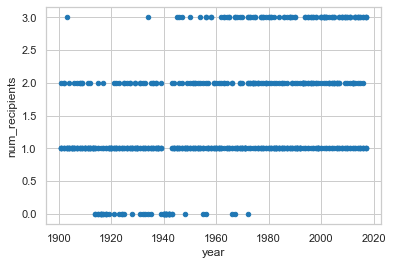

In [91]:
df_awards_past.plot.scatter(x='year', y='num_recipients');

It's hard to see a trend when there are multiple observations per year (**why?**).

Let's try looking at *total* num recipients by year.

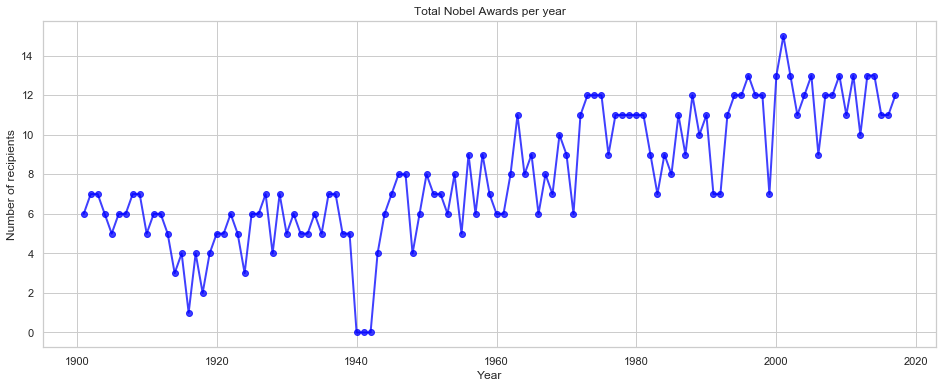

In [88]:
plt.figure(figsize=[16,6])
# plt.plot(df_awards_past.groupby('year').num_recipients.sum(), color = 'b', linewidth='2')
plt.plot(df_awards_past.groupby('year').num_recipients.sum(),  '-ob', linewidth='2', alpha = 0.75)

plt.title('Total Nobel Awards per year')
plt.xlabel('Year')
plt.ylabel('Number of recipients')
plt.grid('on')
plt.show();

Check out the years 1940-43? Any comment? 

Any trends the last 25 years?

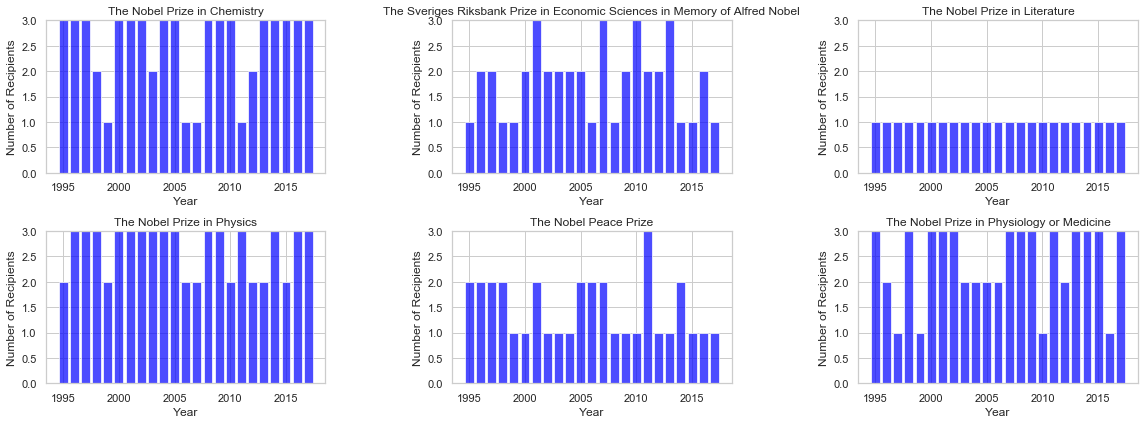

In [89]:
plt.figure(figsize=[16,6])
i = 0
for award in set(df_awards_past.title):
    i += 1
    year = df_awards_past[df_awards_past['title']==award].year
    recips = df_awards_past[df_awards_past['title']==award].num_recipients
    index = year>2019-25
    years_filtered = year[index].values
    recips_filtered = recips[index].values
    plt.subplot(2,3,i)
    plt.bar(years_filtered,recips_filtered, color='b', alpha = 0.7)
    plt.title(award)
    plt.xlabel('Year')
    plt.ylabel('Number of Recipients')
    plt.ylim(0, 3)
plt.tight_layout()

----------------
### End of Standard Section
---------------

## Extra: Did anyone recieve the Nobel Prize more than once (based upon scraped data)?

Here's where it bites us that our original DataFrame isn't "tidy". Let's make a tidy one.

In [ ]:
tidy_awards = []
for idx, row in df_awards_past.iterrows():
    for recipient in row['recipients']:
        tidy_awards.append(dict(
            recipient=recipient,
            year=row['year']))
tidy_awards_df = pd.DataFrame(tidy_awards)
tidy_awards_df.info()

Now we can look at each recipient individually.

In [ ]:
tidy_awards_df.recipient.value_counts()

## Extra: Other structured data formats: JSON and CSV

### CSV
CSV is a lowest-common-denominator format for tabular data.

In [ ]:
df_awards_past.to_csv('../data/awards.csv', index=False)
with open('../data/awards.csv', 'r') as f:
    print(f.read()[:1000])

It loses some info, though: the recipients list became a plain string, and the reader needs to guess whether each column is numeric or not.

In [ ]:
pd.read_csv('../data/awards.csv').recipients.iloc[20]

### JSON

JSON preserves structured data, but fewer data-science tools speak it.

In [ ]:
df_awards_past.to_json('../data/awards.json', orient='records')

with open('../data/awards.json', 'r') as f:
    print(f.read()[:1000])

Lists and other basic data types are preserved. (Custom data types aren't preserved, but you'll get an error when saving.)

In [ ]:
pd.read_json('../data/awards.json').recipients.iloc[20]

## Extra: Pickle: handy for storing data
For temporary data storage in a single version of Python, `pickle`s will preserve your data even more faithfully, even many custom data types. But don't count on it for exchanging data or long-term storage. (In fact, don't try to load untrusted `pickle`s -- they can run arbitrary code!)

In [ ]:
df_awards_past.to_pickle('../data/awards.pkl')
with open('../data/awards.pkl', 'r', encoding='latin1') as f:
    print(f.read()[:200])

Yup, lots of internal Python and Pandas stuff...

In [ ]:
pd.read_pickle('../data/awards.pkl').recipients.iloc[20]

## Extra: Formatted data output

Let's make a textual table of Physics laureates by year, earliest first:

In [ ]:
for idx, row in df_awards_past.sort_values('year').iterrows():
    if 'Physics' in row['title']:
        print('{}: {}'.format(
            row['year'],
            ', '.join(row['recipients'])))


## Extra: Parsing JSON to get the Wayback Machine URL

We could go to http://archive.org, search for our URL, and get the URL for the archived version there. But since you'll often need to talk with APIs, let's take this opportunity to use the Wayback Machine's [API](https://archive.org/help/wayback_api.php). This will also give us a chance to practice working with JSON.

In [ ]:
url = "https://www.nobelprize.org/prizes/lists/all-nobel-prizes/"
# All 3 of these do the same thing. The third is my (KCA's) favorite new feature of Python 3.6.
wayback_query_url = 'http://archive.org/wayback/available?url={}'.format(url)
wayback_query_url = 'http://archive.org/wayback/available?url={url}'.format(url=url)
wayback_query_url = f'http://archive.org/wayback/available?url={url}'
r = requests.get(wayback_query_url)

We got some kind of response... what is it?

In [ ]:
r.text

Yay, [JSON](https://en.wikipedia.org/wiki/JSON)! It's usually pretty easy to work with JSON, once we parse it.

In [ ]:
json.loads(r.text)

Loading responses as JSON is so common that `requests` has a convenience method for it:

In [ ]:
response_json = r.json()
response_json

**What kind of object is this?**

A little Python syntax review: **How can we get the snapshot URL?**

In [ ]:
snapshot_url = response_json['archived_snapshots']['closest']['url']
snapshot_url